In [1]:
# 「Chest X-Ray Images(Pnuemonia)」で肺炎か診断
#  前処理で保存した特徴量、ターゲットから
#  データを拡張して学習する
#  正常データに対する再現率が悪いので、正常系データのみ拡張してみる

In [2]:
import numpy as np
import pandas as pd

import cv2

import matplotlib.pyplot as plt

import keras as ks
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.utils import np_utils
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score, f1_score

import os
import glob

%matplotlib inline


In [3]:
# path の設定
test_path = "./dataset/chest_xray/test/"
train_path ='./dataset/chest_xray/train/'

In [4]:
# 訓練データ読み出し
X_train = np.load(train_path + 'X_train.npy')
y_train = np.load(train_path + 'y_train.npy')

In [5]:
X_train.shape, y_train.shape

((5216, 64, 64, 3), (5216,))

In [6]:
# テストデータ読み出し
X_test = np.load(test_path + 'X_test.npy')
y_test = np.load(test_path + 'y_test.npy')

In [7]:
X_test.shape, y_test.shape

((624, 64, 64, 3), (624,))

In [8]:
np.count_nonzero(y_train == 0)

1341

In [9]:
# ImageDataGenerator
data_gen = ImageDataGenerator(
    rotation_range=50,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True
)

In [10]:
y_train_normal = y_train[y_train == 0]

In [11]:
y_train_normal.shape

(1341,)

In [12]:
# 正常データのみ抜き出し
X_train_normal = X_train[np.where(y_train == 0)]

In [13]:
X_train_normal.shape

(1341, 64, 64, 3)

In [14]:
aug_img = np.empty((X_train_normal.shape))

In [15]:
aug_img.shape

(1341, 64, 64, 3)

In [16]:
# 訓練データの加工

for i, batch in enumerate(data_gen.flow(X_train_normal, shuffle=False, batch_size=1, seed=42)):
    if i >= aug_img.shape[0]:
        break

    aug_img[i] = batch
    

In [17]:
aug_img[0]

array([[[0.09983774, 0.09983774, 0.09983774],
        [0.1030009 , 0.1030009 , 0.1030009 ],
        [0.10665707, 0.10665707, 0.10665707],
        ...,
        [0.40932149, 0.40932149, 0.40932149],
        [0.42291859, 0.42291859, 0.42291859],
        [0.41809502, 0.41809502, 0.41809502]],

       [[0.08327107, 0.08327107, 0.08327107],
        [0.08801582, 0.08801582, 0.08801582],
        [0.09190574, 0.09190574, 0.09190574],
        ...,
        [0.42509457, 0.42509457, 0.42509457],
        [0.43196264, 0.43196264, 0.43196264],
        [0.44263497, 0.44263497, 0.44263497]],

       [[0.06268076, 0.06268076, 0.06268076],
        [0.06663471, 0.06663471, 0.06663471],
        [0.07137308, 0.07137308, 0.07137308],
        ...,
        [0.45586693, 0.45586693, 0.45586693],
        [0.44488773, 0.44488773, 0.44488773],
        [0.47600874, 0.47600874, 0.47600874]],

       ...,

       [[0.49040803, 0.49040803, 0.49040803],
        [0.5577212 , 0.5577212 , 0.5577212 ],
        [0.60318071, 0

In [18]:
len(aug_img)

1341

Text(0.5, 1.0, 'Augmented_2')

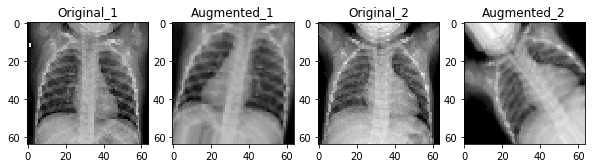

In [19]:
# 加工データの確認
fix, ax = plt.subplots(1, 4, figsize=(10, 10))

# 元データ
plt.subplot(141)
plt.imshow(X_train_normal[0])
plt.title('Original_1')

# 加工データ
plt.subplot(142)
plt.imshow(aug_img[0])
plt.title('Augmented_1')

# 元データ
plt.subplot(143)
plt.imshow(X_train_normal[1])
plt.title('Original_2')

# 加工データ
plt.subplot(144)
plt.imshow(aug_img[1])
plt.title('Augmented_2')


In [40]:
# 前回と同じ構造で
aug_model = Sequential()
aug_model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(64, 64, 3)))
aug_model.add(MaxPooling2D(pool_size=(2, 2)))
aug_model.add(Dropout(0.25))
aug_model.add(Flatten())
aug_model.add(Dense(128, activation='relu'))
aug_model.add(Dropout(0.33))
aug_model.add(Dense(1, activation='sigmoid'))

aug_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 31, 31, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 30752)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               3936384   
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                

In [41]:
# コンパイル
aug_model.compile(loss='binary_crossentropy',
                  optimizer=Adam(lr=0.00001),
                  metrics=['accuracy'])

In [42]:
# EarlyStopping
callbacks = EarlyStopping(monitor='val_loss', patience=5)

In [43]:
aug_model.fit_generator(
    # 訓練データに拡張した正常データを追加
    data_gen.flow(np.r_[X_train_normal, X_train], np.r_[y_train_normal, y_train], batch_size=32, seed=42),
#     steps_per_epoch=163,
    steps_per_epoch=205,
    epochs=20,
    verbose=1,
    shuffle=True,
    callbacks=[callbacks],
    validation_data=(X_test, y_test)
)

Epoch 1/20
205/205 [==============================] - 29s 141ms/step - loss: 0.6603 - accuracy: 0.6113 - val_loss: 0.6120 - val_accuracy: 0.7628
Epoch 2/20
205/205 [==============================] - 25s 121ms/step - loss: 0.5879 - accuracy: 0.7060 - val_loss: 0.5638 - val_accuracy: 0.7179
Epoch 3/20
205/205 [==============================] - 25s 122ms/step - loss: 0.5264 - accuracy: 0.7534 - val_loss: 0.4792 - val_accuracy: 0.7981
Epoch 4/20
205/205 [==============================] - 25s 121ms/step - loss: 0.4832 - accuracy: 0.7938 - val_loss: 0.4478 - val_accuracy: 0.8029
Epoch 5/20
205/205 [==============================] - 25s 122ms/step - loss: 0.4479 - accuracy: 0.8113 - val_loss: 0.4695 - val_accuracy: 0.7692
Epoch 6/20
205/205 [==============================] - 25s 123ms/step - loss: 0.4178 - accuracy: 0.8310 - val_loss: 0.4547 - val_accuracy: 0.7708
Epoch 7/20
205/205 [==============================] - 25s 123ms/step - loss: 0.4028 - accuracy: 0.8344 - val_loss: 0.4728 - val_ac

In [44]:
aug_y_pred = aug_model.predict_classes(X_test)

In [45]:
confusion_matrix(y_test, aug_y_pred)

array([[229,   5],
       [175, 215]], dtype=int64)

In [46]:
accuracy_score(y_test, aug_y_pred)

0.7115384615384616

In [47]:
precision_score(y_test, aug_y_pred)

0.9772727272727273

In [48]:
recall_score(y_test, aug_y_pred)

0.5512820512820513

In [49]:
f1_score(y_test, aug_y_pred)

0.7049180327868853

In [30]:
# 前回と同じ構造で
aug2_model = Sequential()
aug2_model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(64, 64, 3)))
aug2_model.add(MaxPooling2D(pool_size=(2, 2)))
aug2_model.add(Dropout(0.25))
aug2_model.add(Flatten())
aug2_model.add(Dense(128, activation='relu'))
aug2_model.add(Dropout(0.33))
aug2_model.add(Dense(1, activation='sigmoid'))

aug2_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 31, 31, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 30752)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               3936384   
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

In [31]:
# コンパイル
aug2_model.compile(loss='binary_crossentropy',
                  optimizer=Adam(lr=0.00001),
                  metrics=['accuracy'])

In [32]:
# EarlyStopping
callbacks = EarlyStopping(monitor='val_loss', patience=5)

In [33]:
aug2_model.fit(np.r_[X_train_normal, X_train], np.r_[y_train_normal, y_train],
    callbacks=[callbacks],
    epochs=20,
    validation_data=(X_test, y_test)
)

Train on 6557 samples, validate on 624 samples
Epoch 1/20
6557/6557 [==============================] - 25s 4ms/step - loss: 0.5742 - accuracy: 0.7249 - val_loss: 0.5156 - val_accuracy: 0.7196
Epoch 2/20
6557/6557 [==============================] - 22s 3ms/step - loss: 0.3904 - accuracy: 0.8691 - val_loss: 0.4003 - val_accuracy: 0.8429
Epoch 3/20
6557/6557 [==============================] - 23s 3ms/step - loss: 0.2986 - accuracy: 0.9024 - val_loss: 0.3709 - val_accuracy: 0.8205
Epoch 4/20
6557/6557 [==============================] - 22s 3ms/step - loss: 0.2462 - accuracy: 0.9216 - val_loss: 0.3843 - val_accuracy: 0.8061
Epoch 5/20
6557/6557 [==============================] - 23s 4ms/step - loss: 0.2131 - accuracy: 0.9300 - val_loss: 0.3018 - val_accuracy: 0.8830
Epoch 6/20
6557/6557 [==============================] - 22s 3ms/step - loss: 0.1879 - accuracy: 0.9358 - val_loss: 0.3551 - val_accuracy: 0.8253
Epoch 7/20
6557/6557 [==============================] - 22s 3ms/step - loss: 0.1700

In [34]:
aug2_y_pred = aug2_model.predict_classes(X_test)

In [35]:
confusion_matrix(y_test, aug2_y_pred)

array([[142,  92],
       [ 11, 379]], dtype=int64)

In [36]:
accuracy_score(y_test, aug2_y_pred)

0.8349358974358975

In [37]:
precision_score(y_test, aug2_y_pred)

0.8046709129511678

In [38]:
recall_score(y_test, aug2_y_pred)

0.9717948717948718

In [39]:
f1_score(y_test, aug2_y_pred)

0.8803716608594657